In [1]:
import os
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy.integrate import odeint
from Utils.Models import *
from Utils.EABCSMC import *
from Utils.Preconditioning import *
import time

%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

In [2]:
def SIRD_reduced_90_new(z, t, beta0, gamma, kappa, mu0):

    I, R, D = z
    
    S0 = kappa * 10000 * beta0
    S = S0 - I - R - D
    mu = mu0 * (1/(t+1))
    beta = beta0* np.exp(-(0.10377 * beta0) * t)
    dS = - beta * I * S / S0
    dI = beta * I * S / S0 - gamma * I - mu * I
    dR = gamma * I 
    dD = mu * I

    dzdt = [dI, dR, dD]
    return dzdt

In [45]:
italy = pd.read_csv('Data/Sird_bigdata.csv')
italy.fillna(0, inplace = True)

Precond = Preconditioner(SIRD_reduced_90_new)

eff = 100
Precond.preprocess_data(data=italy, start=0, eff=eff, ext=150)

In [126]:
sigma = []
for j in range(1,4):
    if j ==3:
        j =  1.6
    if j ==2:
        j = 1.8
    for i in range(1,eff+1):
        if i%7==0:
            sigma.append(4/ (i*j**2))
        else:
            sigma.append(1 / (i*j**2))
      
sigma = np.array(sigma)
sigma.shape

(300,)

In [127]:
popt, pcov = Precond.fit(p0 = (0.1, 0.1, 10, 0.1), bounds=([0, 0, 0, 0], [3, 7, 6000, 3]), std = sigma )

In [128]:
popt

array([4.18223532e-01, 2.47864156e-02, 6.00000000e+03, 3.09258159e-01])

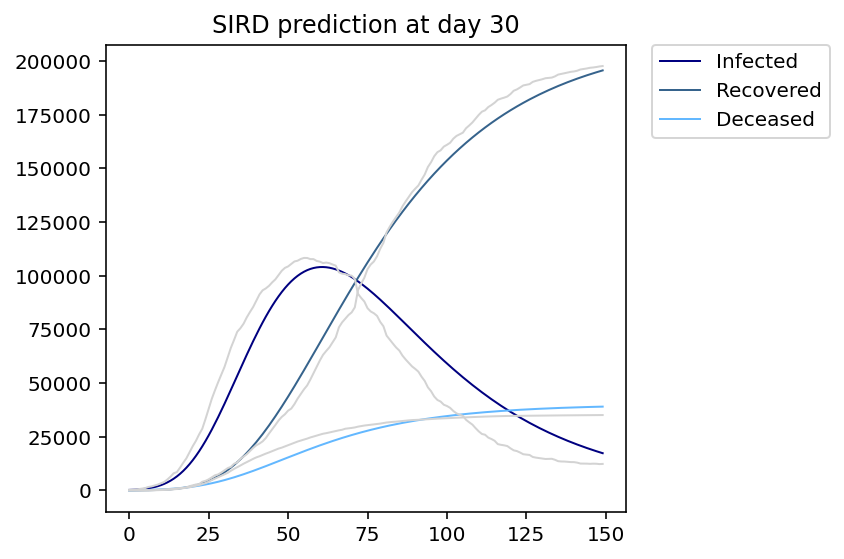

In [130]:
simul_yy =  odeint(SIRD_reduced_90_new, (221,7,1), np.arange(150), args=tuple(np.reshape(popt,(1,-1))[0]))
plot_traj_SIRD(simul_yy)
plot_traj_gray_SIRD(Precond.extended_y)

In [131]:
lambda_ranges = [lambda: npr.uniform(low = 0.5, high = 5), lambda: npr.uniform(low = 0.5, high = 5), lambda: npr.uniform(low = 0.5, high = 5),
                 lambda: npr.uniform(low = 10, high = 20)]
prior_means =  np.array([ 0.28802481,  0.03922435,  10,  0.06892933])

Sampler = EABCSMCSampler(true_y = Precond.true_yy, ODEmodel = Precond.fit_odeint, num_param = len(popt), numerical_estimate = popt, final_time = 100,
                         sigma = sigma, lambda_ranges = lambda_ranges, prior_means = prior_means, n_jobs = 4)

  0%|                                                                                        | 0/50000 [00:00<?, ?it/s]

Borders estimation start...


  0%|                                                                              | 24/25000 [00:00<01:56, 214.86it/s]

Acceptance rate:  0.0001
Borders estimation completed, starting preprocessing...
Borders: [0.3977697875060351, 0.013759682598921527, 33.813095783038, 0.10292224288255013]


  0%|                                                                              | 24/25000 [00:00<02:00, 207.45it/s]

Acceptance rate:  0.00856
Preprocessing completed, starting ABC-SMC


  0%|                                                                              | 40/25000 [00:00<01:06, 374.84it/s]

Acceptance rate:  0.01208
ABS-SMC round :  2


  0%|                                                                             | 24/150000 [00:00<12:27, 200.54it/s]

Acceptance rate:  0.02444
ABS-SMC round :  3


100%|█████████████████████████████████████████████████████████████████████████| 150000/150000 [20:15<00:00, 123.38it/s]


Acceptance rate:  0.05016


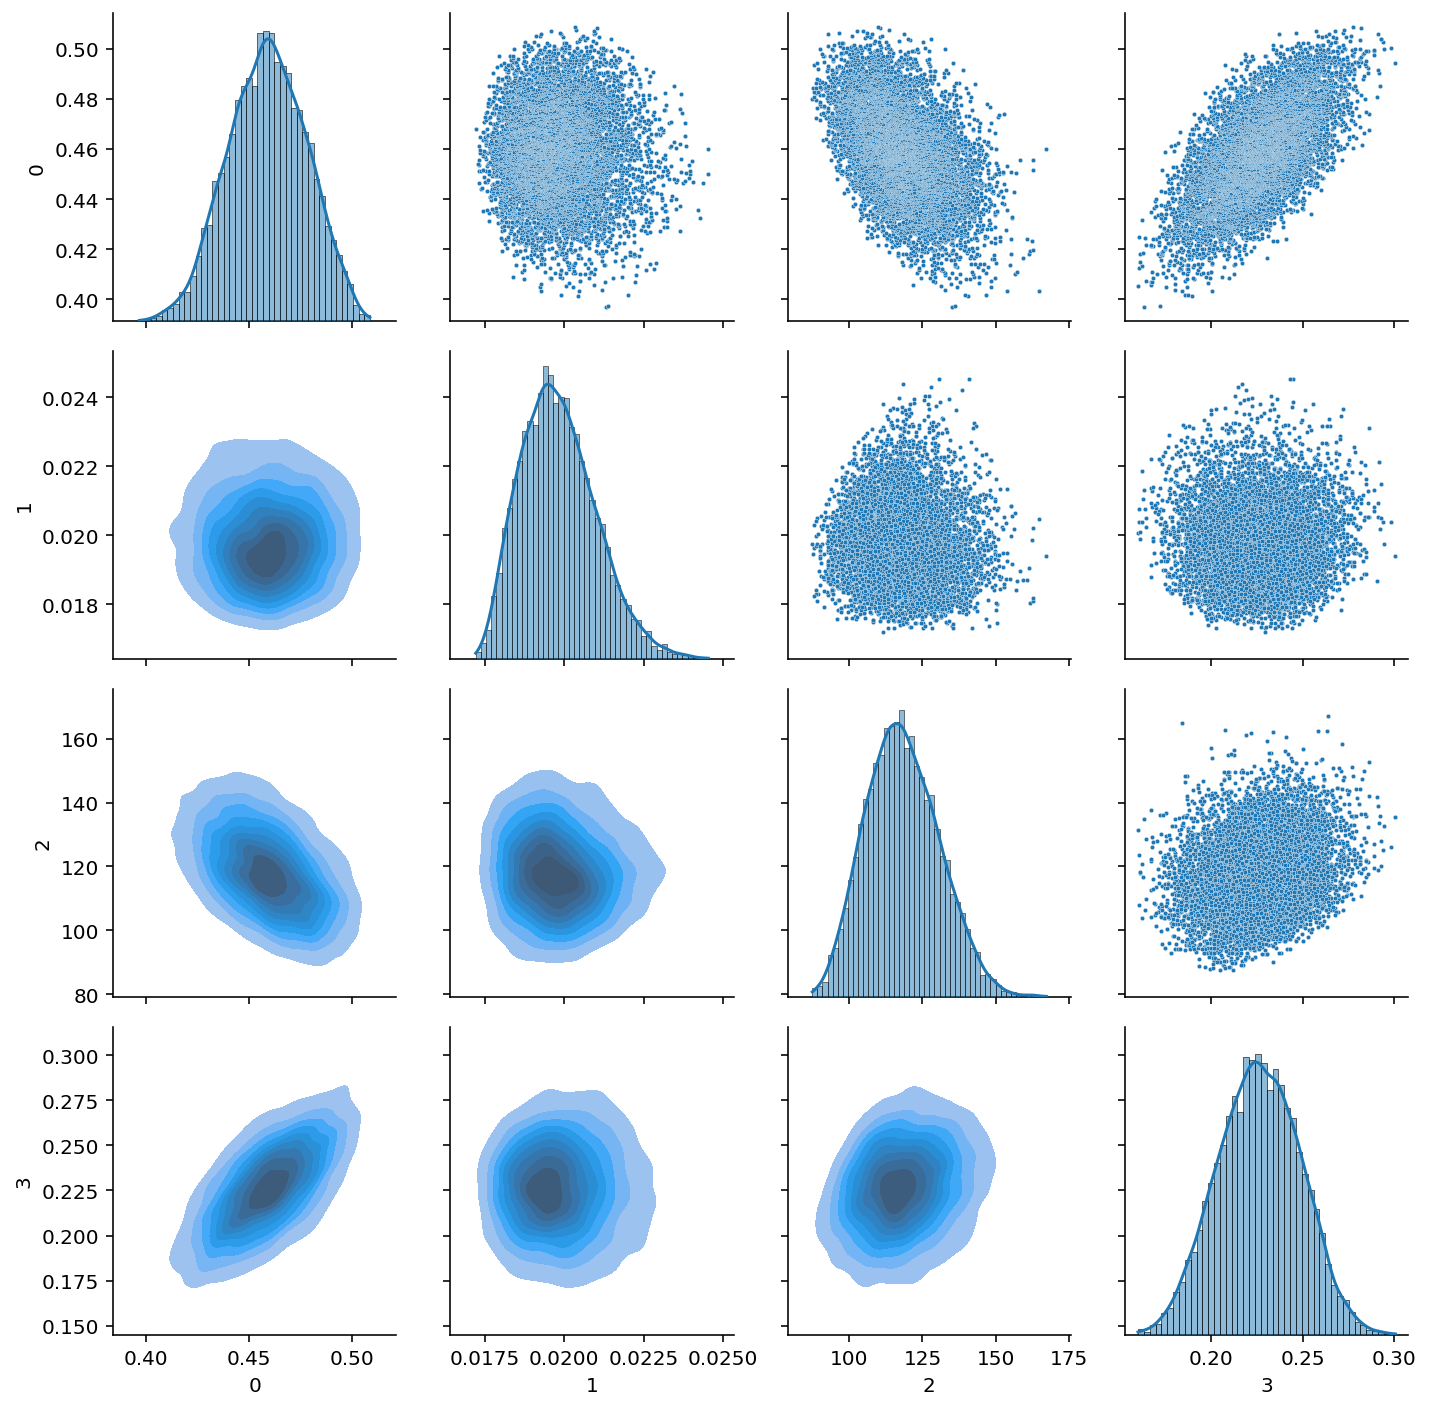

In [132]:
Sampler.fit(niters=5000, eps_schedule=[2, 1, 1/2, 1/3, 1/4], niters_schedule=[10, 5, 5, 5, 10])
Sampler.pairplot()

In [133]:
parameters = Sampler.parameters

In [136]:
def plot_traj_SIRD(trajectories, width=1.):
    x2 = trajectories[:, 0]
    x3 = trajectories[:, 1]
    x4 = trajectories[:, 2]

    i = plt.plot(x2, linewidth=width, label='Infected', color = 'navy')
    r = plt.plot(x3, linewidth=width, label='Recovered', color = (.21,.39,.55))
    d = plt.plot(x4, linewidth=width, label='Deceased', color = (0.39,.72,1))

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # plt.title('Real SIRD')
    plt.title('SIRD prediction at day 30')
    plt.tight_layout()
    
def plot_traj_SIRD2(trajectories, width=1.):
    x2 = trajectories[:, 0]
    x3 = trajectories[:, 1]
    x4 = trajectories[:, 2]
    color_ = (0,0,0.5)
    

    i = plt.plot(x2, linewidth=width/3,color = 'navy', linestyle = 'dashed' )
    r = plt.plot(x3, linewidth=width/3, color = (.21,.39,.55), linestyle = 'dashed')
    d = plt.plot(x4, linewidth=width/3,  color = (0.39,.72,1), linestyle = 'dashed')

    # plt.title('Real SIRD')
    plt.tight_layout()

100%|█████████████████████████████████████████████████████████████████████████████| 7524/7524 [00:42<00:00, 177.89it/s]


106345.51029914085 132766.26767291667
49.0 56.0
55
108257.0


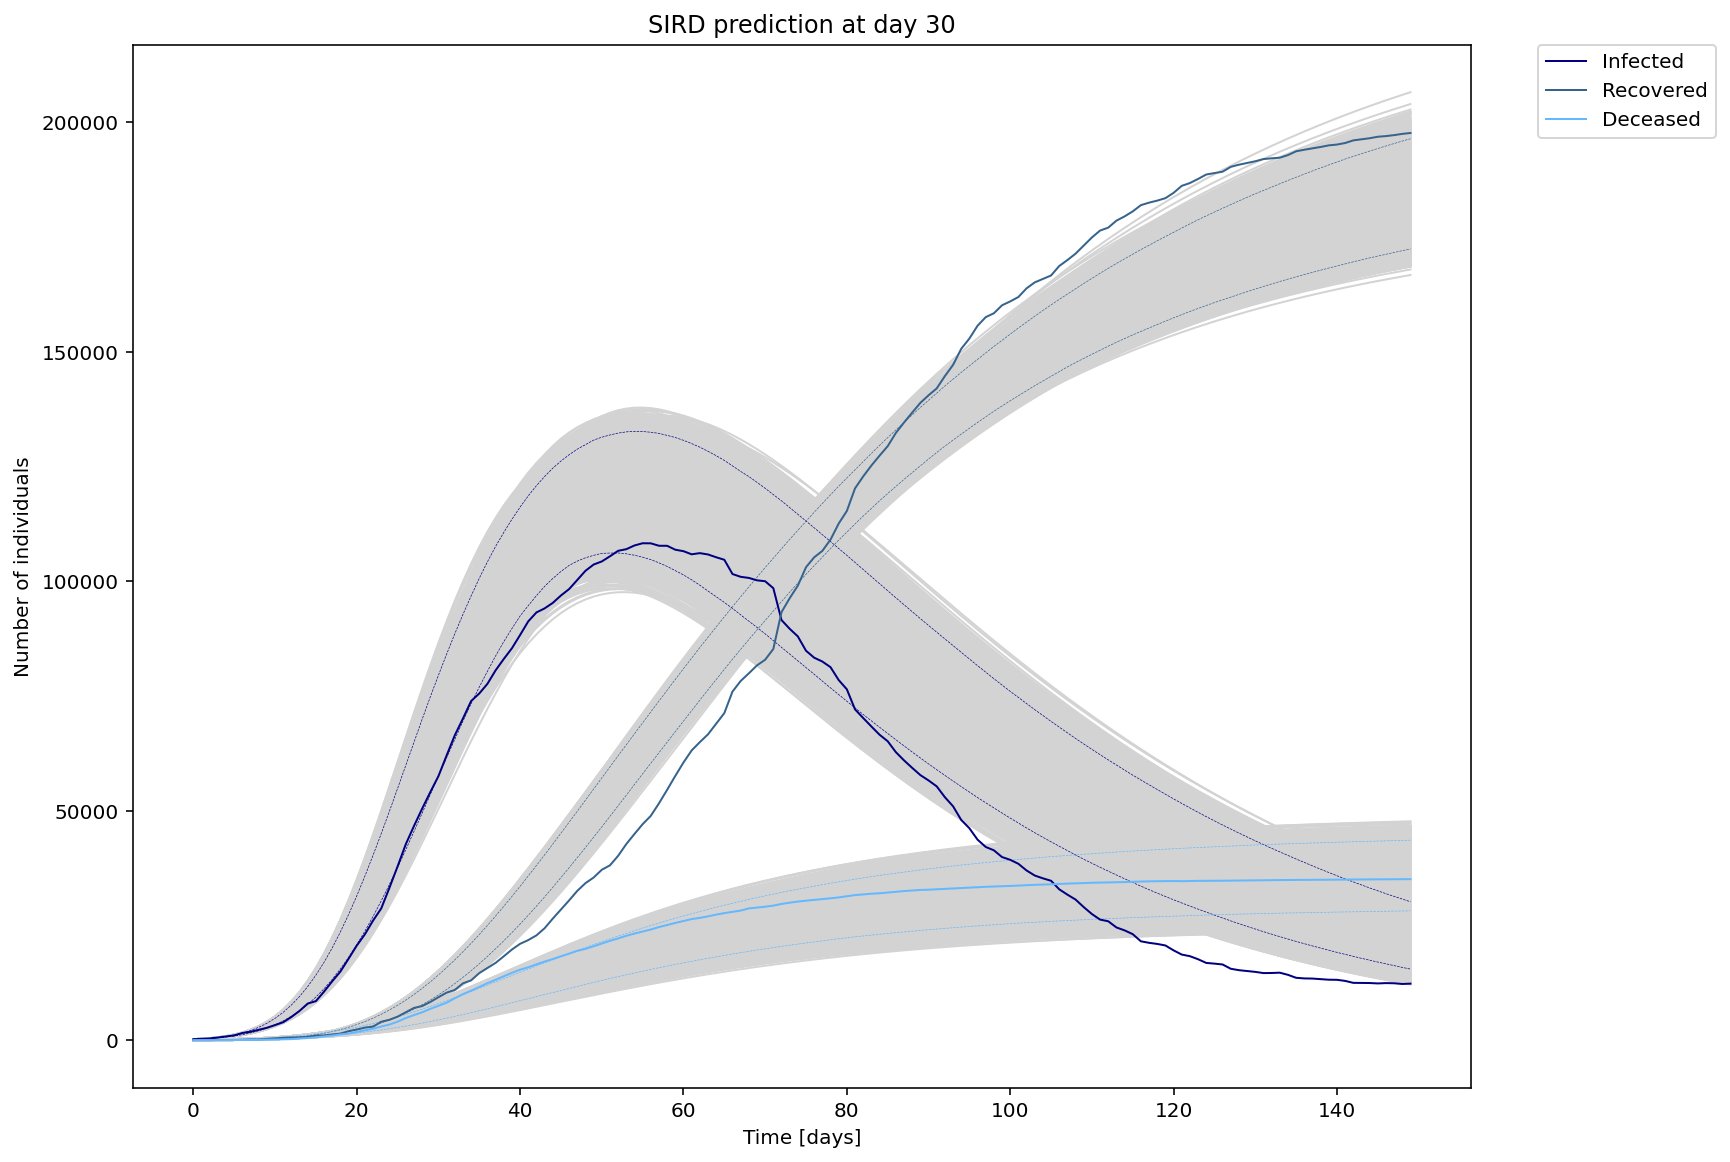

<Figure size 432x288 with 0 Axes>

In [137]:
# magari anche questo lo metto dentro all'abc sampler

fig = plt.figure(figsize = (12,8))

peak = []
day_peak = []
simul_all = []

for j in tqdm(range(parameters.shape[0])):
    simul_yy =  odeint(SIRD_reduced_90_new, [221,1,7], np.arange(150), args=tuple(parameters[j]))
    simul_all.append(simul_yy)
    plot_traj_gray_SIRD(simul_yy)
    peak.append(max(simul_yy[:,0]))
    day_peak.append(np.argmax(simul_yy[:,0])) 

simul_all = np.array(simul_all)
q95 = []
q05 = []
mean = []
sd = []
for i in range(150):
    q95.append([np.quantile(simul_all[:,i,0],0.975),np.quantile(simul_all[:,i,1],0.975),np.quantile(simul_all[:,i,2],0.975)])
    q05.append([np.quantile(simul_all[:,i,0],0.025),np.quantile(simul_all[:,i,1],0.025),np.quantile(simul_all[:,i,2],0.025)])
    mean.append([np.mean(simul_all[:,i,0]),np.mean(simul_all[:,i,1]),np.mean(simul_all[:,i,2])])
    sd.append([np.std(simul_all[:,i,0]),np.std(simul_all[:,i,1]),np.std(simul_all[:,i,2])])

q95 = np.array(q95)    
q05 = np.array(q05)   
    
plot_traj_SIRD2(q95)

plot_traj_SIRD2(q05)

plot_traj_SIRD(Precond.extended_y)

print(np.quantile(peak,0.025), np.quantile(peak,0.975))
print(np.quantile(day_peak,0.025), np.quantile(day_peak,0.975))
print(np.argmax(Precond.extended_y[:,0]))
print(np.max(Precond.extended_y[:,0]))

plt.ylabel('Number of individuals')
plt.xlabel('Time [days]')
plt.show()

plt.savefig('Sird_30days.png')

In [ ]:
PBR = 0
for i in range(31,150):
    PBR += np.sum([(Precond.extended_y[i][j] - mean[i][j] / sd[i][j])**2 for j in range(2)])

In [ ]:
PBR

In [ ]:
t = np.arange(150)

fig = plt.figure(figsize = (10,7))

day_max = []

for j in range(parameters.shape[0]):
    plt.plot(t, parameters[j,0]* np.exp(-(9.72588371e-02 * parameters[j,0]) * t)/((parameters[j,3]/(t+1)) + parameters[j,1]), linewidth = 1, color = 'lightgray')
    day_max.append(np.argmax(parameters[j,0]* np.exp(-(1.713e-2 + 7.094e-02 * parameters[j,0]) * t)/((parameters[j,3]/(t+1)) + parameters[j,1])))
    
print(min(day_max), max(day_max))  
plt.title('Rt predicted by SIRD model')
plt.ylabel('Predicted Rt')
plt.xlabel('Time [days]')
plt.figure();

In [ ]:
np.quantile(params[:,2],0.025) * 100000 * np.quantile(params[:,0],0.025) , np.quantile(params[:,2],0.975) * 100000 * np.quantile(params[:,0],0.975) 

In [ ]:
np.quantile(params[:,0],0.025) ,  np.quantile(params[:,0],0.975) 